This notebook estimates the number of V100 GPU-days used to train our adversaries.

In [1]:
import collections
import datetime
import glob
import os
import pathlib
import pprint
import re
from typing import Dict, Mapping, Optional, Union

import dateutil.parser
import matplotlib.pyplot as plt
import numpy as np

import utils

HOURS_TO_SECONDS = 60 * 60
DAYS_TO_SECONDS = 24 * 60 * 60
# Estimate of how many V100 GPU-days is 1 A6000 GPU-day using this data:
# https://www.notion.so/chaiberkeley/Benchmark-KataGo-victimplay-on-different-hardware-295ac2d430404430b8a1e0232f72b240
# - On cp505, 3 A6000 victimplay workers generated 250k rows in 9h30m and 7
#   V100 workers generated 250k rows in 6h44m. This corresponds to an A6000 worker
#   being 1.6538x faster.
# - On cp127, 3 A6000 workers generated 1002027 rows in 16h03 and 7 V100 workers
#   generated 1019074 rows in 12h16. This corresponds to an A6000 worker being
#   1.7535x faster.
# - The mean of 1.6537 and 1.7535 is 1.7036.
#
# Comparison:
# - At https://lambdalabs.com/gpu-benchmarks with fp16 precision,
#   Lambda measures the conversion factor to be 1.48.
A6000_TO_V100_GPU_DAY = 1.703643

plt.style.use(
    ["tableau-colorblind10", utils.get_style("default"), utils.get_style("1-col")]
)

## Conversions to A6000 GPU-days

Our adversaries were trained using A6000, A4000, A100 40GB,
and A100 80GB GPUs. We'll estimate how many A6000 GPU-days is
1 GPU-day on each of these GPU types.

In [2]:
def get_victimplay_log_line_timestamp(line: str) -> Optional[datetime.datetime]:
    """Fetches the timestamp from a line in a victimplay log file."""
    match = re.match(r"([0-9 \-+:]+): ", line)
    if match is None:
        return None
    return dateutil.parser.parse(match.group(1))


def get_victimplay_duration(log_filename: str) -> Optional[float]:
    """Returns how long the victimplay worker was generating games.

    Args:
      log_filename: Filename of the victimplay worker's log file.

    Returns:
        How long the worker was generating games in seconds.
        Returns None if the worker did not generate any games.
    """
    GAME_START_REGEX = re.compile(r"starting game")
    TIMESTAMP_REGEX = re.compile(r"([0-9 \-+:]+): ")
    with open(log_filename, "r") as f:
        first_game_start_timestamp = None
        for line in f:
            if GAME_START_REGEX.search(line) is not None:
                first_game_start_timestamp = get_victimplay_log_line_timestamp(line)
                assert first_game_start_timestamp is not None
                break
        if first_game_start_timestamp is None:
            return None

        for line in f:
            pass
        last_line = line
        last_timestamp = get_victimplay_log_line_timestamp(last_line)
        assert last_timestamp is not None
        return (last_timestamp - first_game_start_timestamp).total_seconds()


def get_victimplay_games_finished(log_filename: str, game_limit=None) -> int:
    """Returns the number of games the victimplay worker completed.

    Args:
        log_filename: Filename of the victimplay worker's log file.
        game_limit: If not None, then stop counting and return early if
          this number of games is reached.
    """
    GAME_FINISH_REGEX = re.compile("Game #")
    num_games_finished = 0
    with open(log_filename, "r") as f:
        for line in f:
            if GAME_FINISH_REGEX.search(line) is not None:
                num_games_finished += 1
                if game_limit is not None and num_games_finished >= game_limit:
                    break
    return num_games_finished


def get_victimplay_gpu_type(log_filename: str) -> Optional[str]:
    """Parses GPU type from victimplay log."""
    GPU_TYPE_REGEX = re.compile(r"Found GPU (.*) memory")
    with open(log_filename, "r") as f:
        for line in f:
            match = GPU_TYPE_REGEX.search(line)
            if match is not None:
                return match.group(1)
    return None

In [3]:
# Victimplay runs on different GPU types with the same adversary+victim setup.
# Experiment link: https://www.notion.so/chaiberkeley/adv-s300mil-v600-vs-cp505-v8-benchmarking-by-GPU-6b151352b64241d2a67c21b6fb1c8da6
benchmarking_directories = [
    "/nas/ucb/k8/go-attack/victimplay/ttseng-bench-a100-40gb-20230203-163919",
    "/nas/ucb/k8/go-attack/victimplay/ttseng-bench-a100-80gb-20230203-163757",
    "/nas/ucb/k8/go-attack/victimplay/ttseng-bench-a4000-20230203-163607",
    "/nas/ucb/k8/go-attack/victimplay/ttseng-bench-a6000-20230203-163319",
    "/nas/ucb/k8/go-attack/victimplay/ttseng-bench-a100-40gb-20230206-131111",
    "/nas/ucb/k8/go-attack/victimplay/ttseng-bench-a100-80gb-20230206-124106",
    "/nas/ucb/k8/go-attack/victimplay/ttseng-bench-a4000-20230206-124105",
    "/nas/ucb/k8/go-attack/victimplay/ttseng-bench-a6000-20230206-121545",
]

# We'll count the number of games each victimplay worker completed
# as a proxy for how performant the GPU type is for our workload.

# Key = GPU type
# Value = List of number of victimplay games per hour
#        (1 entry for each victimplay worker)
gpu_type_to_game_throughputs = collections.defaultdict(list)
for directory in benchmarking_directories:
    victimplay_logfiles = glob.glob(f"{directory}/selfplay/log*.log")
    for logfile in victimplay_logfiles:
        duration = get_victimplay_duration(logfile)
        if duration is None:
            continue
        gpu_type = get_victimplay_gpu_type(logfile)
        assert gpu_type is not None
        games_finished = get_victimplay_games_finished(logfile)
        throughput = games_finished / (duration / HOURS_TO_SECONDS)
        gpu_type_to_game_throughputs[gpu_type].append(throughput)

gpu_type_to_avg_throughput = {}
for gpu_type, throughputs in gpu_type_to_game_throughputs.items():
    avg = np.mean(throughputs)
    stddev = np.std(throughputs)
    print(f"{gpu_type} throughput: Avg. {avg} +- {stddev}")
    gpu_type_to_avg_throughput[gpu_type] = avg

a6000_throughput = gpu_type_to_avg_throughput["NVIDIA RTX A6000"]
# Key = GPU type
# Value = Estimate of how many A6000 GPU-days is 1 GPU-day
#         of this GPU type.
gpu_type_to_a6000_gpu_days = {
    gpu_type: throughput / a6000_throughput
    for gpu_type, throughput in gpu_type_to_avg_throughput.items()
}

# Comparison points:
# - https://www.notion.so/chaiberkeley/Benchmark-KataGo-victimplay-on-different-hardware-295ac2d430404430b8a1e0232f72b240
#     1 A100 40GB GPU-day -> 1.2592 A6000 GPU-days
#
# - Eyeballing from the actual training victimplay logs in ttseng-avoid-pass-alive-coldstart-39-20221025-175949,
#   I (tomtseng) got the following numbers:
#     1 A4000 GPU-day     -> 0.6619 A6000 GPU-days
#     1 A100 40GB GPU-day -> 1.3507 A6000 GPU-days
#     1 A100 80GB GPU-day -> 1.5829 A6000 GPU-days
# - At https://lambdalabs.com/gpu-benchmarks with fp16 precision, Lambda estimates
#     1 A4000 GPU-day     -> 0.4275 A6000 GPU-days
#     1 A100 40GB GPU-day -> 1.5541 A6000 GPU-days
#     1 A100 80GB GPU-day -> 1.8378 A6000 GPU-days
print("Conversions to A6000 GPU-days:")
pprint.pprint(gpu_type_to_a6000_gpu_days)

NVIDIA A100-SXM4-40GB throughput: Avg. 180.94829353581846 +- 7.091347343534531
NVIDIA A100-SXM4-80GB throughput: Avg. 202.9935724100512 +- 1.4472585304743872
NVIDIA RTX A4000 throughput: Avg. 67.93128417907852 +- 2.071138168948876
NVIDIA RTX A6000 throughput: Avg. 108.38931872111866 +- 1.2438836439931913
Conversions to A6000 GPU-days:
{'NVIDIA A100-SXM4-40GB': 1.6694291990282837,
 'NVIDIA A100-SXM4-80GB': 1.8728189715108872,
 'NVIDIA RTX A4000': 0.6267341190128057,
 'NVIDIA RTX A6000': 1.0}


## V100 GPU-days used for training adversaries

In [4]:
def get_modified_time(filename: Union[pathlib.Path, str]) -> datetime.datetime:
    """Returns the modified time of a file."""
    epoch_time = os.path.getmtime(filename)
    return datetime.datetime.utcfromtimestamp(epoch_time)


def get_adversary_written_time(
    training_path: pathlib.Path,
    adversary_steps: int,
):
    """Returns when the adversary model file was written."""
    adversary_files = glob.glob(
        str(training_path / "models" / f"t0-s{adversary_steps}-d*" / "model.bin.gz")
    )
    assert len(adversary_files) == 1
    return get_modified_time(adversary_files[0])


def get_victimplay_gpu_days(
    training_path: pathlib.Path,
    adversary_steps: int,
) -> Dict[str, float]:
    """Returns the GPU-days used by the adversary's victimplay workers.

    Args:
        training_path: Output directory of the adversary's training run.
        adversary_name: Name of the adversary.

    Returns:
        Dictionary mapping GPU type to how many GPU-seconds were used of
        that GPU during victimplay.
    """
    CREATION_TIME_REGEX = re.compile(r"log(\d{8}-\d{6})-")

    gpu_type_to_seconds = collections.defaultdict(int)
    adversary_written_time = get_adversary_written_time(training_path, adversary_steps)
    victimplay_logfiles = glob.glob(str(training_path / "selfplay" / "log*.log"))
    for logfile in victimplay_logfiles:
        finished_a_game = get_victimplay_games_finished(logfile, game_limit=1) > 0
        if not finished_a_game:
            # This victimplay worker didn't generate any data, so we'll just skip
            # it. E.g., the cyclic-adversary had many workers crash early and not
            # generate any data on Nov. 1 due to a bug.
            continue

        # Parse creation time (in UTC) from filename.
        creation_time_match = CREATION_TIME_REGEX.search(logfile)
        assert creation_time_match is not None
        creation_time = dateutil.parser.parse(creation_time_match.group(1))
        if creation_time > adversary_written_time:
            continue

        modified_time = min(get_modified_time(logfile), adversary_written_time)
        time_alive_seconds = (modified_time - creation_time).total_seconds()
        gpu_type = get_victimplay_gpu_type(logfile)
        assert gpu_type is not None
        gpu_type_to_seconds[gpu_type] += time_alive_seconds
    return gpu_type_to_seconds


def get_train_gpu_days(
    training_path: pathlib.Path,
    adversary_steps: int,
) -> Dict[str, float]:
    """Returns the GPU-days used by the adversary's train worker."""
    EPOCH_NUMBER_REGEX = re.compile(r"BEGINNING NEXT EPOCH ([0-9]+)")
    TIMESTAMP_REGEX = re.compile(r"Current time: ([0-9 \-+:.]+)")
    GPU_REGEX = re.compile(r"name: (.*) major:")

    gpu_type_to_seconds = collections.defaultdict(int)
    adversary_written_time = get_adversary_written_time(training_path, adversary_steps)
    train_logfile = training_path / "train" / "t0" / "stdout.txt"
    with open(train_logfile, "r") as f:
        prev_epoch = 0
        prev_timestamp = None
        did_train_this_epoch = False
        gpu_type = None
        for l in f:
            epoch_match = EPOCH_NUMBER_REGEX.match(l)
            if epoch_match is not None:
                epoch = int(epoch_match.group(1))
                if epoch > prev_epoch:
                    # The epoch number incremented, which means we trained
                    # between prev_timestamp and the timestamp of this epoch
                    # (which will appear in two more lines)
                    did_train_this_epoch = True
                prev_epoch = epoch

            timestamp_match = TIMESTAMP_REGEX.match(l)
            if timestamp_match is not None:
                timestamp = dateutil.parser.parse(timestamp_match.group(1))
                if did_train_this_epoch:
                    assert gpu_type is not None
                    gpu_type_to_seconds[gpu_type] += (
                        min(timestamp, adversary_written_time) - prev_timestamp
                    ).total_seconds()
                    did_train_this_epoch = False
                    gpu_type = False
                if timestamp > adversary_written_time:
                    break
                prev_timestamp = timestamp

            gpu_match = GPU_REGEX.match(l)
            if gpu_match is not None:
                gpu_type = gpu_match.group(1)
    return gpu_type_to_seconds


def get_v100_gpu_days(
    training_path: pathlib.Path,
    adversary_steps: int,
    verbose: bool = False,
) -> float:
    """Returns the estimated V100 GPU-days used to train the adversary.

    Args:
        training_path: Output directory of the adversary's training run.
        adversary_name: Name of the adversary.
        verbose: Whether to print out intermediate calculations.
    """
    gpu_type_to_victimplay_seconds = get_victimplay_gpu_days(
        training_path, adversary_steps
    )
    gpu_type_to_train_seconds = get_train_gpu_days(training_path, adversary_steps)
    seconds_dicts = [
        ("victimplay", gpu_type_to_victimplay_seconds),
        ("train", gpu_type_to_train_seconds),
    ]

    total_v100_days = 0
    for descriptor, seconds_dict in seconds_dicts:
        if verbose:
            days_dict = {
                gpu_type: seconds / DAYS_TO_SECONDS
                for gpu_type, seconds in seconds_dict.items()
            }
            print(f"{descriptor} GPU usage:")
            pprint.pprint(days_dict)

        for gpu_type, seconds in seconds_dict.items():
            days = seconds / DAYS_TO_SECONDS
            total_v100_days += (
                days * gpu_type_to_a6000_gpu_days[gpu_type] * A6000_TO_V100_GPU_DAY
            )
    return total_v100_days

In [5]:
v100_days = get_v100_gpu_days(
    pathlib.Path("/nas/ucb/tony/go-attack/training/emcts1-curr/cp127-to-505-v1"),
    34090496,
    verbose=True,
)
print("Pass-adversary V100 GPU days:", v100_days)

victimplay GPU usage:
{'NVIDIA RTX A6000': 1.7000779246759259}
train GPU usage:
{'NVIDIA RTX A6000': 0.10115825417824076}
Pass-adversary V100 GPU days: 3.0686634074516492


In [6]:
CYCLIC_ADV_TRAINING_PATH = pathlib.Path(
    "/nas/ucb/k8/go-attack/victimplay/ttseng-avoid-pass-alive-coldstart-39-20221025-175949"
)
v100_days = get_v100_gpu_days(
    CYCLIC_ADV_TRAINING_PATH,
    545065216,
    verbose=True,
)
print("Cyclic-adversary V100 GPU days:", v100_days)

victimplay GPU usage:
{'NVIDIA A100-SXM4-40GB': 299.65091498769675,
 'NVIDIA A100-SXM4-80GB': 222.4628226519676,
 'NVIDIA RTX A4000': 61.84087257660878,
 'NVIDIA RTX A6000': 347.5863040065741}
train GPU usage:
{'NVIDIA A100-SXM4-80GB': 0.4094241887731483,
 'NVIDIA RTX A6000': 0.9957843217361119}
Cyclic-adversary V100 GPU days: 2223.2289559821224


## Cyclic-adversary GPU-days vs. win rate

We use a lot of GPU-days to train the cyclic-adversary, but perhaps it was already
strong earlier in training. Let's plot GPU-days vs. adversary win rate.

In [7]:
df = utils.parse_sgfs(
    ["/nas/ucb/k8/go-attack/match/ttseng-hard-adv-checkpoint-sweep-s545mil-20230117"]
)
df.victim_name.unique()

array(['cp505h-v4096', 'cp127h-v1', 'cp39h-v1', 'cp505h-v1', 'cp505-v1',
       'cp505-v4096'], dtype=object)

In [8]:
adv_steps_list = sorted(df.adv_steps.unique())
gpu_days_list = []
for adv_steps in adv_steps_list:
    # Note: it would be more efficient to fetch the GPU-days
    # for each adversary in one sweep of the training log files,
    # but here we're doing the easy inefficient way of sweeping
    # through the files for each adversary
    gpu_days_list.append(get_v100_gpu_days(CYCLIC_ADV_TRAINING_PATH, adv_steps))

             adv_win     gpu_days
adv_steps                        
414379008   0.000000   595.185450
424006144   0.000000   615.388675
434127104   0.000000   634.901149
445174528   0.000000   656.277141
455012352   0.000000   674.590325
464995584  12.000000   693.807642
474976512  14.583333   712.869404
484961536  40.000000   731.345387
494657792  64.583333   749.644650
504708864  75.000000   781.309203
515616512  83.333333   832.093124
525883904  87.500000   931.111608
535865088  94.000000  1206.192888
545065216  95.722433  2223.228956
545993728  96.000000  2883.143384


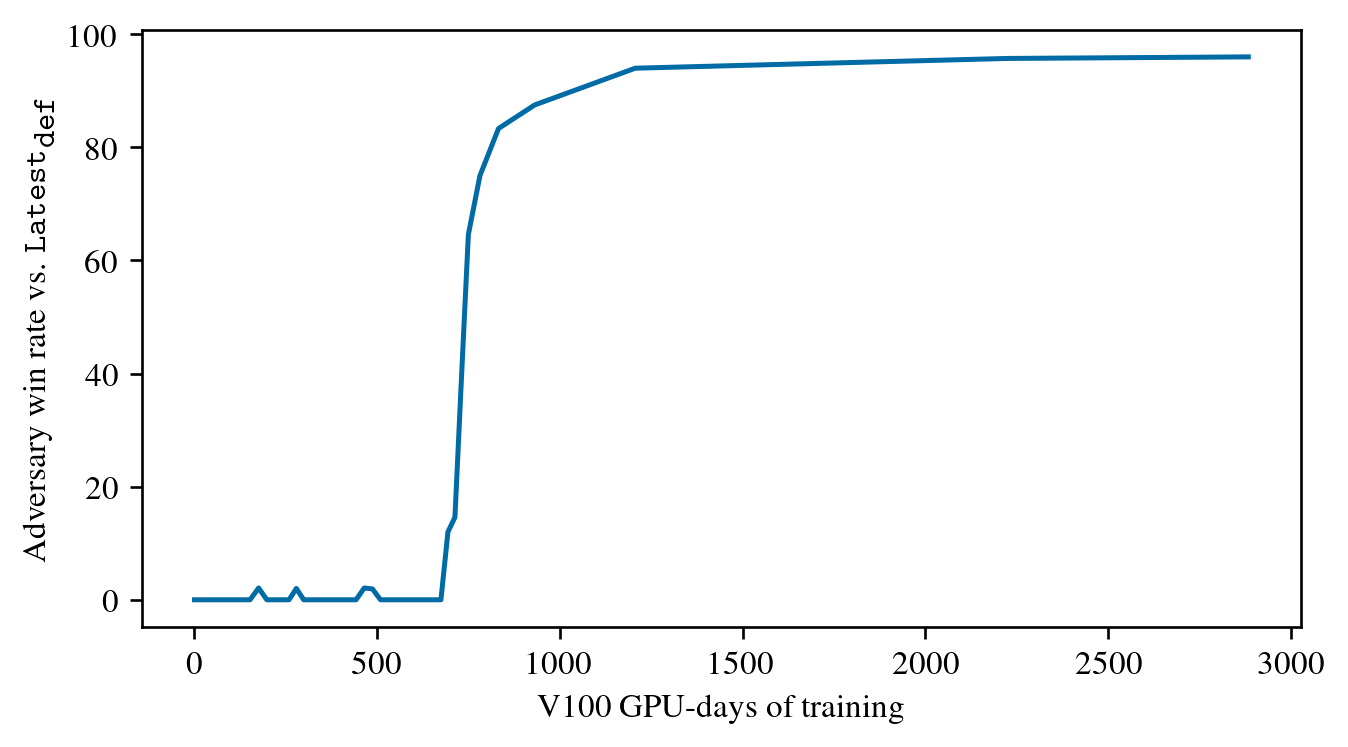

In [9]:
VICTIM_NAME = "cp505h-v4096"
win_rates = (
    df[df.victim_name == VICTIM_NAME]
    .groupby("adv_steps")
    .adv_win.mean(numeric_only=True)
)
win_rates = 100 * win_rates
win_rates_and_gpu_days = win_rates.to_frame()
win_rates_and_gpu_days["gpu_days"] = gpu_days_list
print(win_rates_and_gpu_days.tail(15))
ax = win_rates_and_gpu_days.plot(x="gpu_days", y="adv_win")

ax.get_legend().remove()
ax.set_xlabel("V100 GPU-days of training")
ax.set_ylabel(r"Adversary win rate vs. $\texttt{Latest}_\texttt{def}$")
plt.savefig("win-rate-vs-gpu-days.pgf", backend="pgf")